<a href="https://colab.research.google.com/github/Albly/High_perfomance_python_lab/blob/main/Fractals/Bifurcartion_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 1: Bifurcation diagram**


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

Consider we have a logistic map that can be described as: 

$x_{n+1} = rx_n(1-x_n)$,

where $x_n$ - number between zero and one. It represents the ratio of existing population to the maximum possible population.

Let's see how changes this function if different r parameters.


In [ ]:

# implementing the map
def logistic_map(r, x):
    return r * x * (1 - x)

def plot_evolution(r):
    '''
    Function for plottting state of evolution with defined r
    '''
    x = 0.1
    Y = []
    
    plt.figure(figsize=(20,5))

    # do iterations
    for i in range(35):
        # calculate logistic map
        x = logistic_map(r,x)
        # add result to the list
        Y.append(x)

    #plot graph after all iterations 
    plt.axis()
    plt.style.use('seaborn')
    plt.plot(np.arange(len(Y)), Y,'o-',  alpha=0.7,linewidth=2.0)
    plt.ylabel('population',fontsize = 16)
    plt.xlabel('iteration',fontsize = 16)
    plt.legend(np.round(r,1).astype(np.str), bbox_to_anchor=(1.1, 1.05))


def plot_bifurcation_diagram(r_samples = 10000, r_start = 0, r_end = 4.0, iterations = 1000, last_samples = 100):
    '''
    function for plotting bifurcation diagram
    @r_samples - number of different r values, used for plotting
    @r_start - the first r value
    @r_end - the last r value
    @iterations - number of iterations of logistic map
    @last_samples - number of the last samples, which will be taken for plotting 
    '''

    # create an interval of r-values
    r = np.linspace(r_start, r_end, r_samples)
    # randomly choose x value
    x = np.random.rand()

    plt.figure(figsize=(15,8))
    plt.style.use('default')
    # do iterations
    for iteration in range(iterations):
        # calculate logistic functtion
        x = logistic_map(r,x)

        # check for last samples interval
        if iteration >= (iterations - last_samples):
            #plot point
            plt.plot(r,x,',',color ='#9f1d35',alpha=.28)

    plt.grid( linestyle='-')

    plt.title("Biffurcation diagram",fontsize= 20)
    plt.ylabel('x',fontsize = 17)
    plt.xlabel('r',fontsize = 17)
    plt.show()

If  $0 < r < 1$

then population will inxtinct after some iterations
 

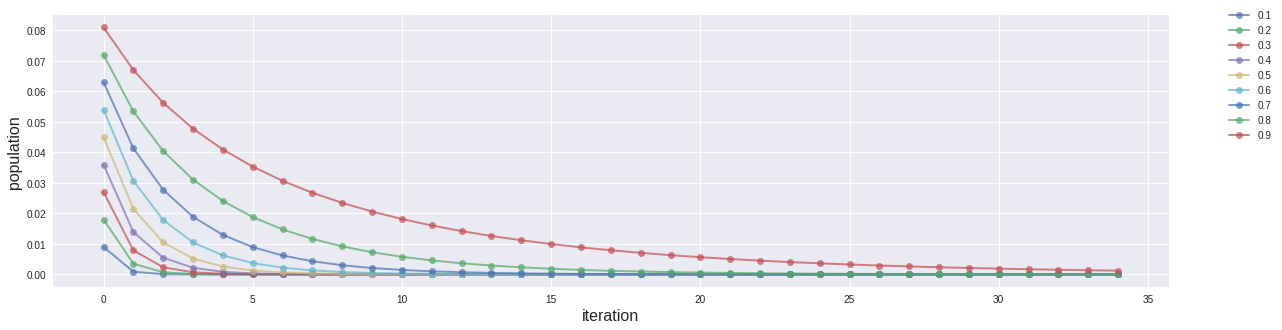

In [ ]:
r = np.linspace(0.1,0.9,9)
plot_evolution(r)

If $1 < r < 2$ 

then population will reach a stationary value $\frac{r-1}{r}$

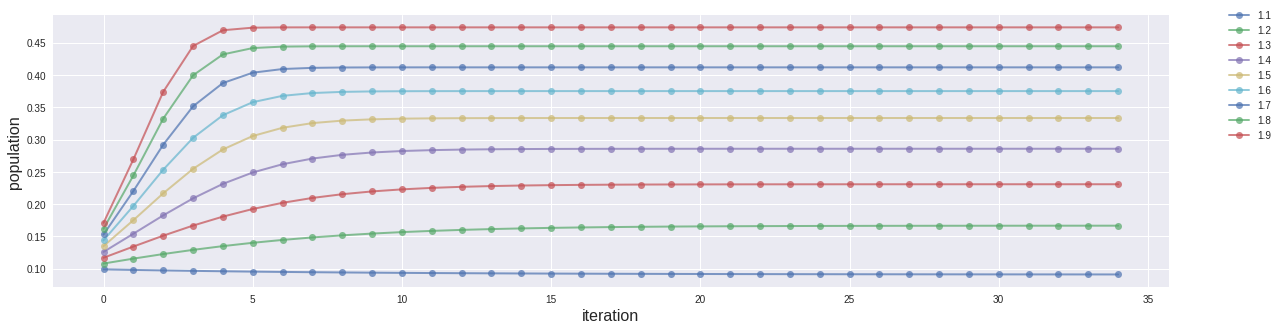

In [ ]:
r = np.linspace(1.1,1.9,9)
plot_evolution(r)

If $2 < r < 3$

then population reach the stationary value, but before this, it fluctuates

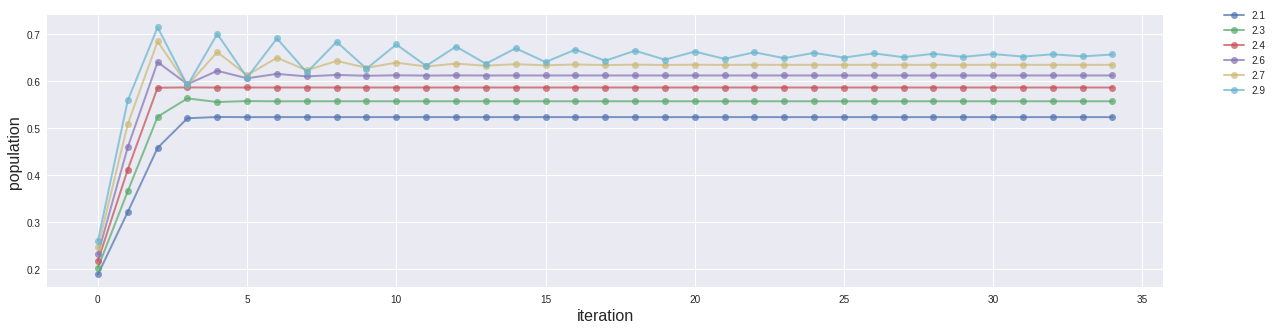

In [ ]:
r = np.linspace(2.1,2.9,6)
plot_evolution(r)

If $3 < r < 1+\sqrt{6}$ 

then population always flusctuates between two values

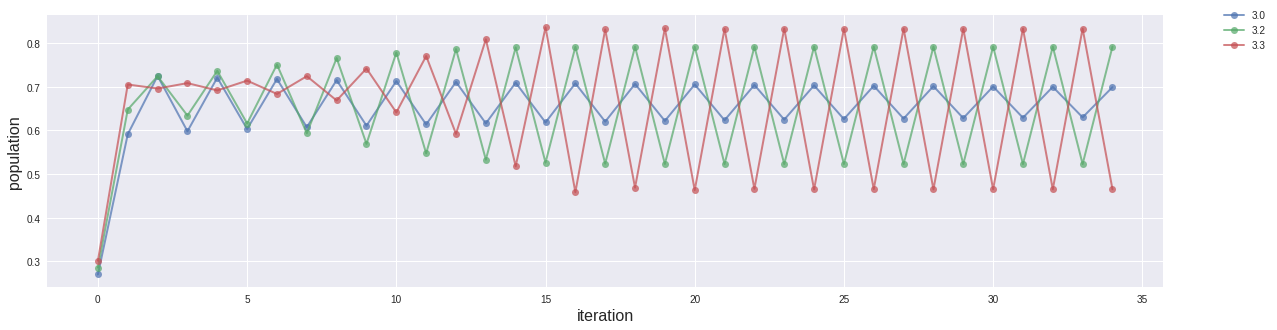

In [ ]:
r = np.linspace(3, 0.9+np.sqrt(6) ,3)
X = plot_evolution(r)

If $1+\sqrt{6} < r < 3.54 $

then population always fluctuates between 4 values

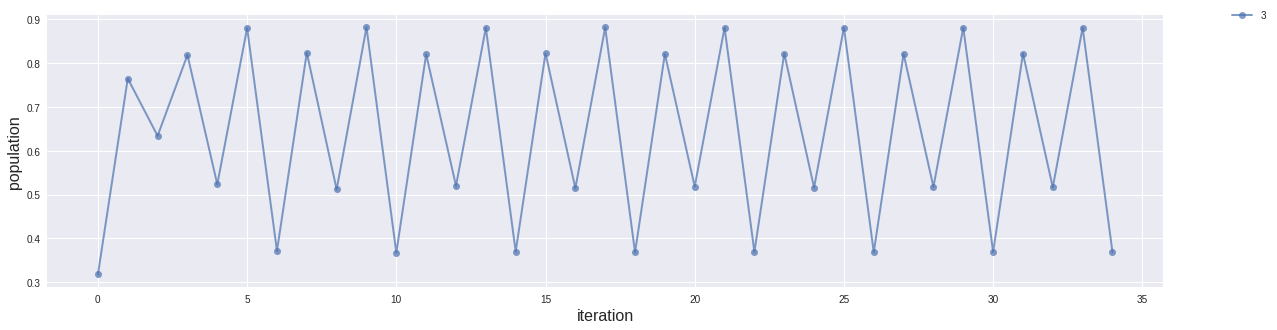

In [ ]:
r = np.linspace(3.45, 3.54, 1)
X = plot_evolution(3.53)

If $r > 3.57$

then we can see chaotic behavior of our system. 

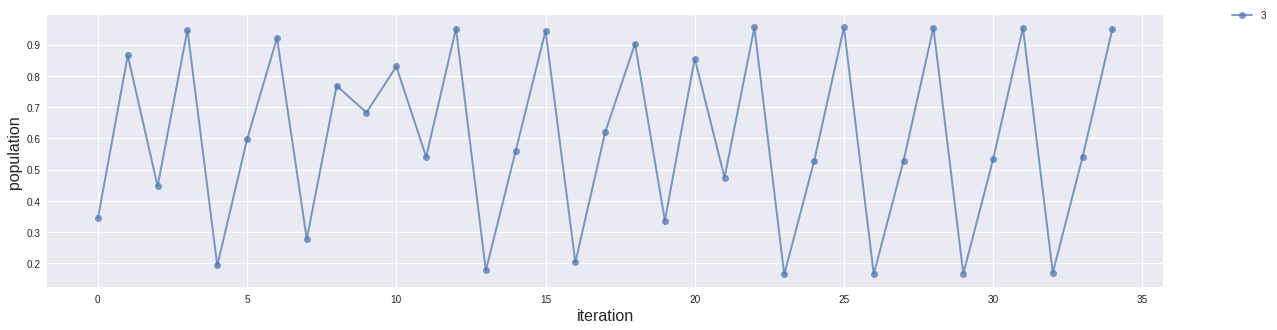

In [ ]:
r = np.linspace(3.55, 3.8, 2)
X = plot_evolution(3.83)

Most values $r > 3.57$ are chaotic. But sometimes we can see some narrow windows, where our system behave stable. We will clearly see them on the biffurcation diagram. But if $r>4$ the sequence diverges


In [ ]:
def plot_bifurcation_diagram(r_samples = 1000, r_start = 0, r_end = 4.0, iterations = 1000, last_samples = 200):
    
    '''
    function for plotting bifurcation diagram
    @r_samples - number of different r values, used for plotting
    @r_start - the first r value
    @r_end - the last r value
    @iterations - number of iterations of logistic map
    @last_samples - number of the last samples, which will be taken for plotting 
    '''

    # x-values and r-values that will be saved for plotting
    X = np.empty((last_samples, r_samples))
    R = np.empty((last_samples, r_samples))

    # r-values
    r = np.linspace(r_start, r_end, r_samples)
    # random x-value
    x = np.random.rand()

    plt.figure(figsize=(15,8))
    for iteration in range(iterations):
        x = r * x * (1 - x)

        if iteration >= (iterations - last_samples):
            X[iteration - (iterations - last_samples) ] = x
            R[iteration - (iterations - last_samples) ] = r 
            
    
    plt.style.use('default')
    plt.plot(R,X,',',color ='#9f1d35',alpha=.28)
    plt.grid( linestyle='-')
    plt.title("Biffurcation diagram",fontsize= 20)
    plt.ylabel('x',fontsize = 17)
    plt.xlabel('r',fontsize = 17)
    plt.show()

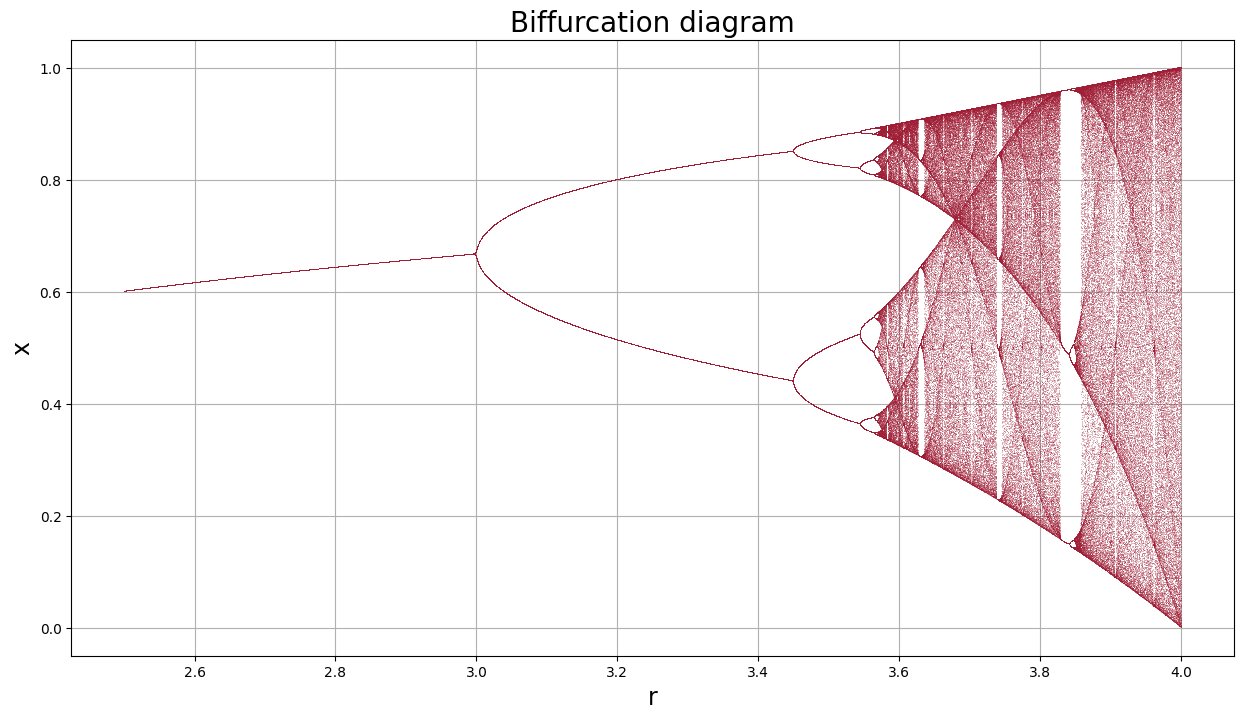

In [ ]:
plot_bifurcation_diagram(r_start=2.5)

Let's create faster realization using MPI.


In [ ]:
!pip install mpi4py 

     |████████████████████████████████| 1.4MB 5.7MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074441 sha256=1169004942471a64aba42d6874245431a74d728cc675217387d97d674a88f5e8
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py


In [ ]:
%%writefile biffurcation.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

def plot_bifurcation_diagram_parallel(rank, n_processes ,r_samples = 50000, r_start = 0, r_end = 4.0, iterations = 2000, last_samples = 300):
    
    #split all samples for processes
    samples_in_process = r_samples // n_processes
    #we may have some modulo after dividing
    last_r_samples = r_samples % n_processes

    #length of the interval where we calculate diagram  
    full_length = r_end - r_start
    #length of parts that will be calculated by processes
    part_length = full_length // n_processes

    #if process is the last
    if rank == n_processes-1:
        #it has to calculate part of data with modulo
        r = np.linspace(r_start + rank*part_length, r_end , samples_in_process + last_r_samples )
    else:
        #other procesess will calculatate parts of the same size
        r = np.linspace(r_start + rank*part_length, r_start + (rank+1) * part_length, samples_in_process)
    
    #Creating arrays for results
    X = np.empty((last_samples, r.shape[0]))
    R = np.empty((last_samples, r.shape[0]))

    #starting from random value
    x = np.random.rand()

    #starting index of iterations that will be added to array 
    last = iterations - last_samples

    #for each iteration
    for iteration in range(iterations):
        #calculate logistic map
        x = r * x * (1 - x)

        # if iterations in interval of the last values
        if iteration >= last:
            #add them to array
            X[iteration - last] = x
            R[iteration - last] = r 

    return X,R 


#creating mpi communicator
comm = MPI.COMM_WORLD
#getting number of processes
n_proc = comm.Get_size() 
#getting current process
rank = comm.Get_rank() 

#if it's our root process
if rank == 0:
    #save time of starting
    print('n_processes = ', n_proc)
    t0 = MPI.Wtime() 

#do calculations
X,R = plot_bifurcation_diagram_parallel(rank, n_proc)
#combine results
X,R = comm.gather(X, root=0), comm.gather(R, root=0)

#if it's the root process
if rank == 0:

    #calculate time of running the program
    time = np.round(MPI.Wtime() - t0, 4)
    print(time, 'sec')
    #save it to file
    np.savez('n_Proc'+str(n_proc), time)

    # if we had 10 processes
    if(n_proc==10):
        #plot a diagram
        plt.figure(figsize=(5,3))
        plt.style.use('default')
        for i in range(n_proc):
            plt.plot(R[i],X[i],',',color ='#9f1d35',alpha=.28)
        plt.grid( linestyle='-')
        plt.title("Biffurcation diagram",fontsize= 14)
        plt.ylabel('x',fontsize = 12)
        plt.xlabel('r',fontsize = 12)
        plt.savefig('Biffurcation_diagram', dpi = 200)
        plt.close()

Overwriting biffurcation.py


Here we run our MPI version (Jupiter version)

In [ ]:
!mpiexec -n 1 python biffurcation.py
!mpiexec -n 2 python biffurcation.py
!mpiexec -n 3 python biffurcation.py
!mpiexec -n 4 python biffurcation.py
!mpiexec -n 9 python biffurcation.py
!mpiexec -n 5 python biffurcation.py
!mpiexec -n 6 python biffurcation.py
!mpiexec -n 7 python biffurcation.py
!mpiexec -n 8 python biffurcation.py
!mpiexec -n 9 python biffurcation.py
!mpiexec -n 10 python biffurcation.py

n_processes =  1
0.713 sec
n_processes =  2
0.3112 sec
n_processes =  3
0.2969 sec
n_processes =  4
0.2552 sec
n_processes =  9
0.2589 sec
n_processes =  5
0.2047 sec
n_processes =  6
0.1926 sec
n_processes =  7
0.2127 sec
n_processes =  8
0.2562 sec
n_processes =  9
0.1959 sec
n_processes =  10
0.3121 sec


Load the picture, that was plotted

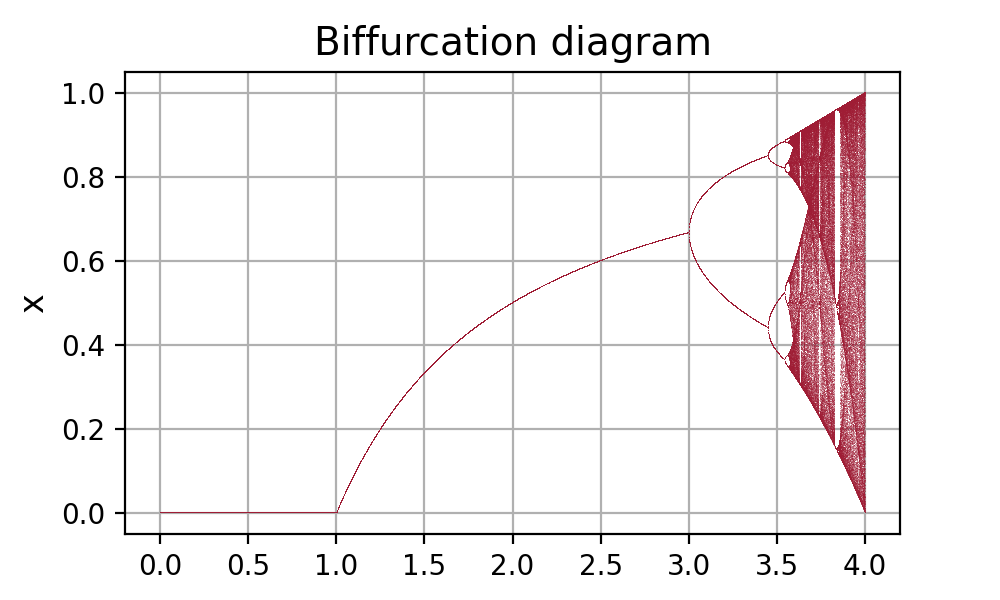

In [ ]:
from IPython.display import Image
Image("Biffurcation_diagram.png")

Here we run our MPI version (Colab version)

We can see that Colab MPI has quite poor results. 

In [ ]:
!mpirun --allow-run-as-root -n 1 python biffurcation.py
!mpirun --allow-run-as-root -n 2 python biffurcation.py
!mpirun --allow-run-as-root -n 3 python biffurcation.py
!mpirun --allow-run-as-root -n 4 python biffurcation.py
!mpirun --allow-run-as-root -n 5 python biffurcation.py
!mpirun --allow-run-as-root -n 6 python biffurcation.py
!mpirun --allow-run-as-root -n 7 python biffurcation.py
!mpirun --allow-run-as-root -n 8 python biffurcation.py
!mpirun --allow-run-as-root -n 9 python biffurcation.py
!mpirun --allow-run-as-root -n 10 python biffurcation.py
from IPython.display import Image
Image("Biffurcation_diagram.png")

n_processes =  1
1.3511 sec
n_processes =  2
1.0742 sec
n_processes =  3
1.1944 sec
n_processes =  4
1.291 sec
n_processes =  5
1.2976 sec
n_processes =  6
1.465 sec
n_processes =  7
1.7727 sec
n_processes =  8
2.482 sec
n_processes =  9
2.437 sec


Let's plot a graph Time vs number of processes
 

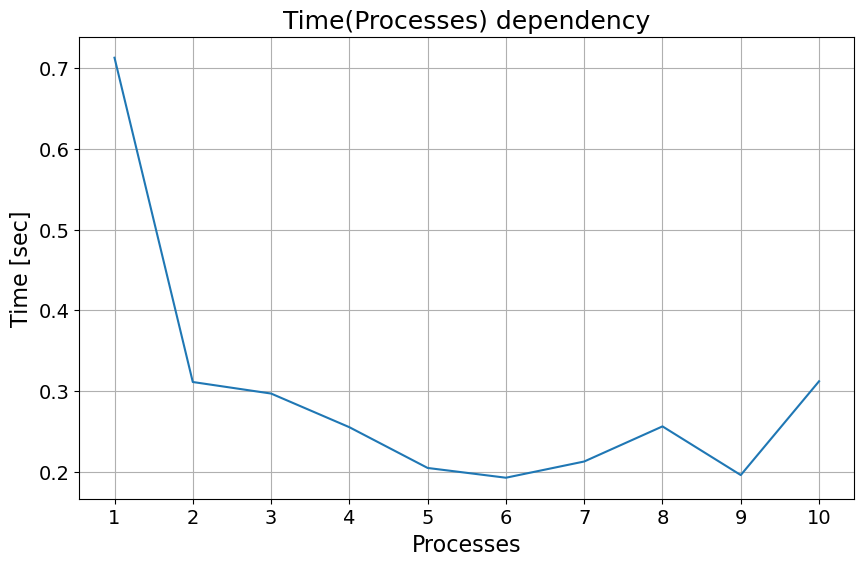

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a = []
b = []
for i in range(1, 11, 1):
    ex = np.load('n_Proc'+str(i)+'.npz')
    a.append((ex['arr_0']))
    b.append(1/(ex['arr_0']))
    
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.title('Time(Processes) dependency', fontsize=18)
plt.ylabel('Time [sec]', fontsize=16)
plt.xlabel('Processes', fontsize=16)
plt.xticks(np.arange(0, 11), np.arange(1, 12), fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(np.arange(10),a);

And Speedup vs number of processes


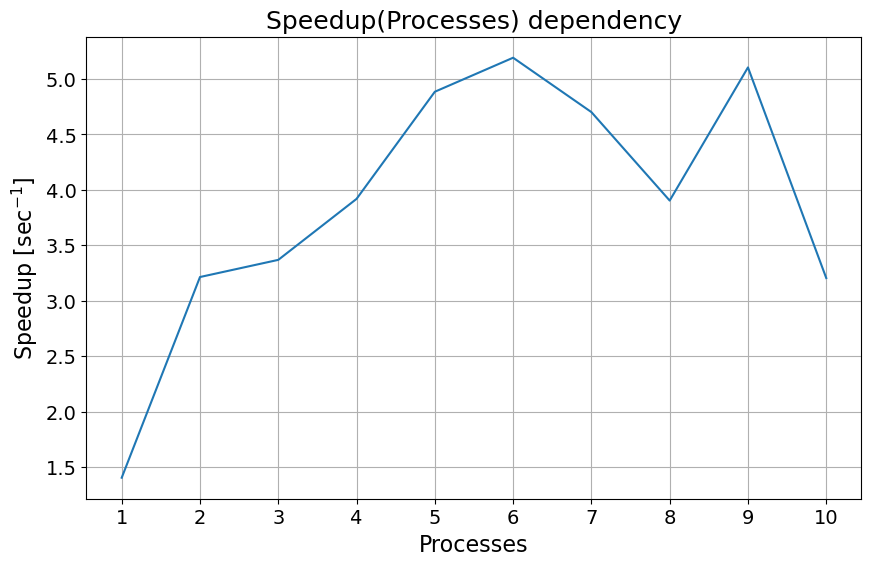

In [ ]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.title('Speedup(Processes) dependency', fontsize=18)
plt.ylabel('Speedup [sec$^{-1}$]', fontsize=16)
plt.xlabel('Processes', fontsize=16)
plt.xticks(np.arange(0, 11), np.arange(1, 12), fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(np.arange(10),b);



---



---



---



# **Second Part**

In this part we will implement calculating of bifurcation map with different ways and compare the results: 

> 1) Usual numpy version


> 2) Numpy + Jit compiler version

> 3) Cupy version (GPU)

> 4) MPI with different number of processes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Numpy implementation

In [ ]:
def get_bifurcation_diagram(r_samples = 10000, r_start = 0, r_end = 4.0, iterations = 1000, last_samples = 200):
    
    X = np.empty((last_samples, r_samples))
    R = np.empty((last_samples, r_samples))

    r = np.linspace(r_start, r_end, r_samples)
    x = np.random.rand()

    for iteration in range(iterations):
        x = r * x * (1 - x)

        if iteration >= (iterations - last_samples):
            X[iteration - (iterations - last_samples) ] = x
            R[iteration - (iterations - last_samples) ] = r 
            
    return R, X

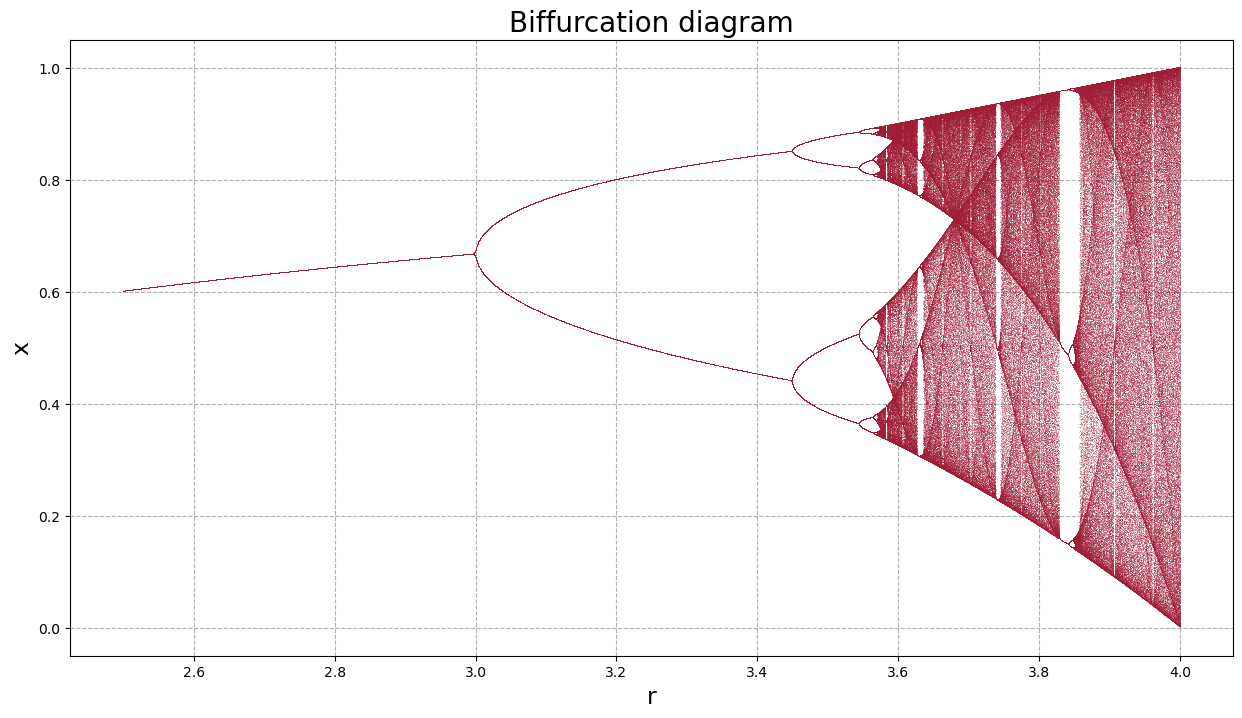

In [ ]:
R,X = get_bifurcation_diagram(r_start=2.5)
plt.figure(figsize=(15,8))
plt.style.use('default')
plt.plot(R,X,',',color ='#9f1d35',alpha=.28)
plt.grid( linestyle='--')
plt.title("Biffurcation diagram",fontsize= 20)
plt.ylabel('x',fontsize = 17)
plt.xlabel('r',fontsize = 17)
plt.show()

## 2. Jit + Numpy


In [ ]:
from numba import njit

In [ ]:
@njit(fastmath=True)
def get_bifurcation_diagram_jit(r_samples = 10000, r_start = 0, r_end = 4.0, iterations = 1000, last_samples = 200):
    
    X = np.empty((last_samples, r_samples))
    R = np.empty((last_samples, r_samples))

    r = np.linspace(r_start, r_end, r_samples)
    x = np.random.rand(r.shape[0])

    for iteration in range(iterations):
        x = r * x * (1 - x)

        if iteration >= (iterations - last_samples):
            X[iteration - (iterations - last_samples) ] = x
            R[iteration - (iterations - last_samples) ] = r 
            
    return R, X

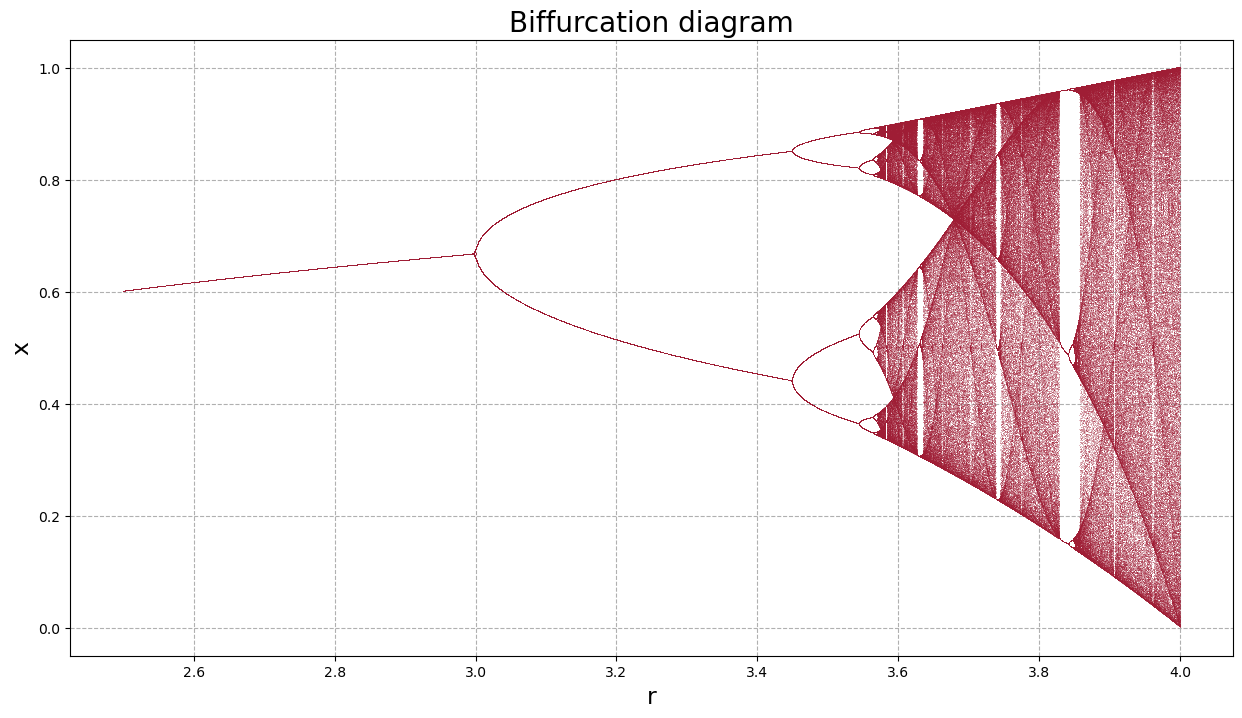

In [ ]:
R,X = get_bifurcation_diagram_jit(r_start=2.5)
plt.figure(figsize=(15,8))
plt.style.use('default')
plt.plot(R,X,',',color ='#9f1d35',alpha=.28)
plt.grid( linestyle='--')
plt.title("Biffurcation diagram",fontsize= 20)
plt.ylabel('x',fontsize = 17)
plt.xlabel('r',fontsize = 17)
plt.show()

## 3. Cupy implementation


In [ ]:
import cupy as cp

In [ ]:
cp.cuda.Device()

<CUDA Device 0>

In [ ]:
def get_bifurcation_diagram_gpu(r_samples = 10000, r_start = 0, r_end = 4.0, iterations = 1000, last_samples = 200):
    
    X = cp.empty((last_samples, r_samples), dtype = cp.float32)
    R = cp.empty((last_samples, r_samples), dtype = cp.float32)

    r = cp.linspace(r_start, r_end, r_samples, dtype = cp.float32)
    x = cp.random.rand(dtype = cp.float32)

    for iteration in range(iterations):
        x = r * x * (1 - x)

        if iteration >= (iterations - last_samples):
            X[iteration - (iterations - last_samples) ] = x
            R[iteration - (iterations - last_samples) ] = r 
    
    return R,X 


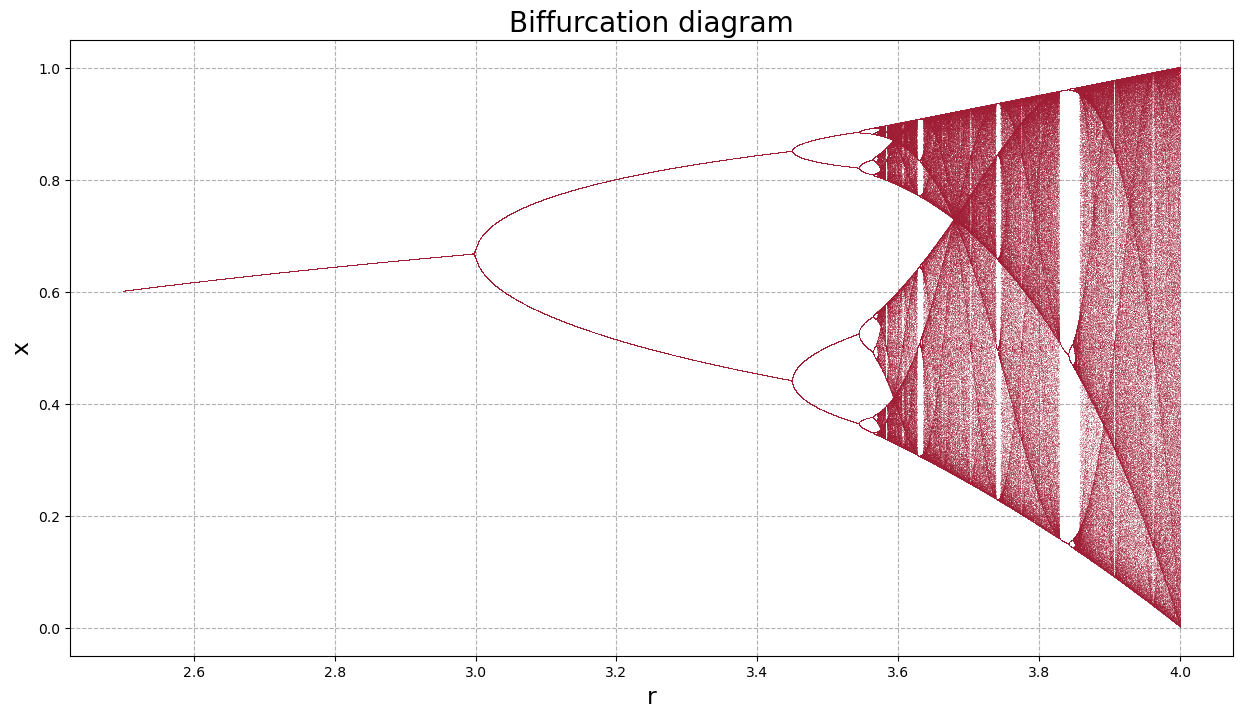

In [ ]:
R,X = get_bifurcation_diagram_gpu(r_start=2.5)
plt.figure(figsize=(15,8))
plt.style.use('default')
plt.plot(R.get(),X.get(),',',color ='#9f1d35',alpha=.28)
plt.grid( linestyle='--')
plt.title("Biffurcation diagram",fontsize= 20)
plt.ylabel('x',fontsize = 17)
plt.xlabel('r',fontsize = 17)
plt.show()

## MPI + numpy

In [ ]:
!pip install mpi4py

In [ ]:
from mpi4py import MPI

In [ ]:
%%writefile biffurcation.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import sys

def plot_bifurcation_diagram_parallel(rank, n_processes ,r_samples = 50000, r_start = 0, r_end = 4.0, iterations = 2000, last_samples = 310):
    
    #split all samples for processes
    samples_in_process = r_samples // n_processes
    #we may have some modulo after dividing
    last_r_samples = r_samples % n_processes

    #length of the interval where we calculate diagram  
    full_length = r_end - r_start
    #length of parts that will be calculated by processes
    part_length = full_length // n_processes

    #if the process is last
    if rank == n_processes-1:
        #it have to calculate part of data with modulo
        r = np.linspace(r_start + rank*part_length, r_end , samples_in_process + last_r_samples )
    else:
        #other procesess will calculatate parts of the same size
        r = np.linspace(r_start + rank*part_length, r_start + (rank+1) * part_length, samples_in_process)
    
    #Creating arrays for results
    X = np.empty((last_samples, r.shape[0]))
    R = np.empty((last_samples, r.shape[0]))

    #starting from random value
    x = np.random.rand()

    #starting index of iterations that will be added to array 
    last = iterations - last_samples

    #for each iteration
    for iteration in range(iterations):
        #calculate logistic map
        x = r * x * (1 - x)

        # if iterations in interval of the last values
        if iteration >= last:
            #add them to array
            X[iteration - last] = x
            R[iteration - last] = r 

    return X,R 

iterations = int(sys.argv[1]) 

#creating mpi communicator
comm = MPI.COMM_WORLD
#getting number of processes
n_proc = comm.Get_size() 
#getting current process
rank = comm.Get_rank() 

#if it's our root process
if rank == 0:
    #save time of starting
    print('n_processes = ', n_proc)
    print('iterations = ', iterations)
    t0 = MPI.Wtime() 

#do calculations
X,R = plot_bifurcation_diagram_parallel(rank, n_proc, r_start = 2.5,  iterations = iterations )
#combine results
X,R = comm.gather(X, root=0), comm.gather(R, root=0)


#if it's the root process
if rank == 0:

    #calculate time of running the program
    time = np.round(MPI.Wtime() - t0, 4)
    
    #for i in range(1, n_proc):
        
    X_out = np.concatenate((X), axis = 1)
    R_out = np.concatenate((R), axis = 1)
    
    print("cat: ", X_out.shape, R_out.shape)
    
    print(time, 'sec')
    #save it to file
    np.savez('bif'+str(n_proc), X=X_out, R=R_out, T = time)


Overwriting biffurcation.py


For Jupiter

In [ ]:
!mpiexec -n 4 python biffurcation.py 1000

n_processes =  4
iterations =  1000
cat:  (310, 50000) (310, 50000)
0.2133 sec


For Colab

In [ ]:
!mpirun --allow-run-as-root -n 4 python biffurcation.py 1000

n_processes =  4
iterations =  1000
1.1707 sec


Again we can see MPI on my laptop works 5 times faster than on Colab ^

Result

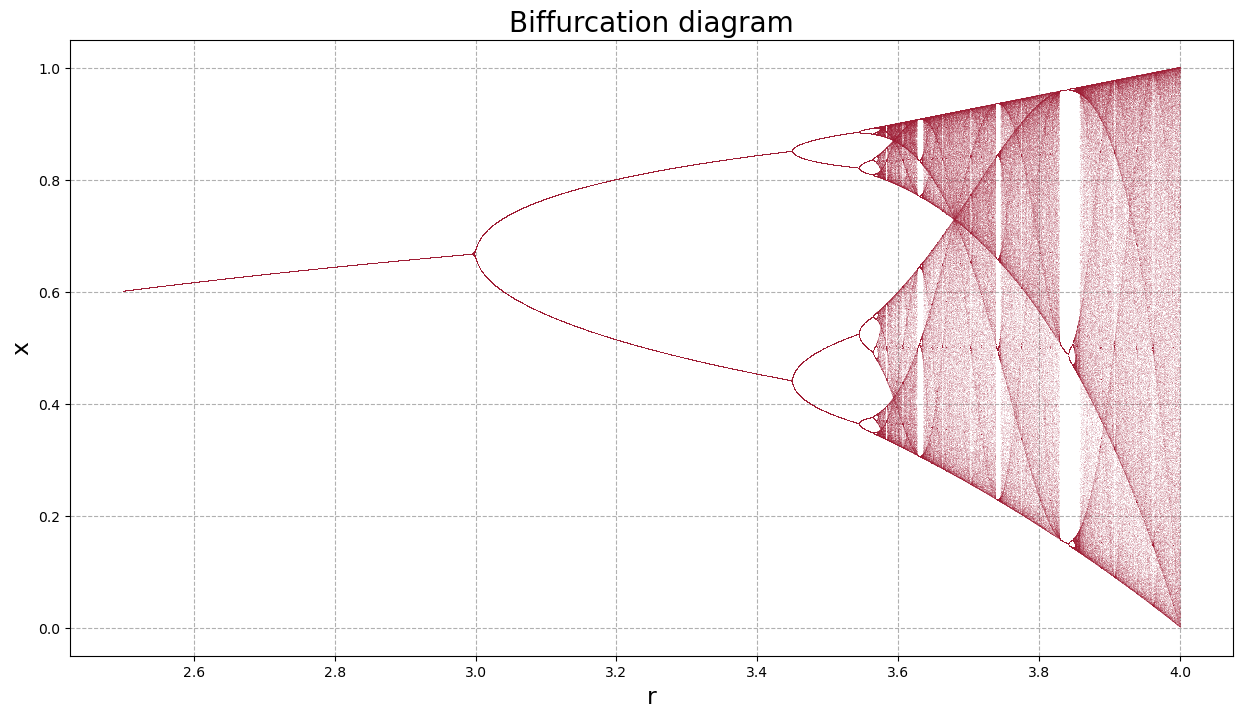

In [ ]:
n_proc = 9
ex = np.load('bif'+str(n_proc)+'.npz')
R = ex['R']
X = ex['X']
time = ex['T']


plt.figure(figsize=(15,8))
plt.style.use('default')
plt.plot(R,X,',',color ='#9f1d35',alpha=.1)
plt.grid( linestyle='--')
plt.title("Biffurcation diagram",fontsize= 20)
plt.ylabel('x',fontsize = 17)
plt.xlabel('r',fontsize = 17)
plt.show()

## **Run all**

In [ ]:
import subprocess
from tqdm import tqdm_notebook as tqdm
import time as time
from statistics import mean

**For Colab**

In [ ]:
np_results =[]
cp_results = []
jit_results = []
mpi_results = []

n_proc_MPI = 4
interval = np.logspace(1,4,20)

for iterations in tqdm(interval):
    iter = int(iterations)

    res_np = %timeit -n100 -r1 -o -q get_bifurcation_diagram(iterations=iter)
    res_cp = %timeit -n100 -r1 -o -q get_bifurcation_diagram_gpu(iterations=iter)
    res_jit = %timeit -n100 -r1 -o -q get_bifurcation_diagram_jit(iterations = iter)
    
    repeats_res = []
    
    for repeat in range(100)
        
        a = subprocess.run(["mpirun","--allow-run-as-root","-n", str(n_proc_MPI), "python", "biffurcation.py" , str(iter)],
                           universal_newlines = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE)

        ex = np.load('bif' + str(n_proc_MPI) + '.npz')
        repeats_res.append(ex['T'])
    
    mpi_results.append(mean(repeats_res))
    jit_results.append(res_jit.best)
    cp_results.append(res_cp.best)
    np_results.append(res_np.best)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
np.logspace(1,4,20)

array([   10.        ,    14.38449888,    20.69138081,    29.76351442,
          42.81332399,    61.58482111,    88.58667904,   127.42749857,
         183.29807108,   263.66508987,   379.26901907,   545.55947812,
         784.75997035,  1128.83789168,  1623.77673919,  2335.72146909,
        3359.81828628,  4832.93023857,  6951.92796178, 10000.        ])

**For Local machine**

In [ ]:
np_results =[]
cp_results = []
jit_results = []

mpi_results = np.zeros((20 , 8))

interval = np.round(np.logspace(1,4,20),0)

for iterations in tqdm(interval):
    iter = int(iterations)

    res_np = %timeit -n10 -r1 -o -q get_bifurcation_diagram(iterations=iter)
    res_cp = %timeit -n10 -r1 -o -q get_bifurcation_diagram_gpu(iterations=iter)
    res_jit = %timeit -n10 -r1 -o -q get_bifurcation_diagram_jit(iterations = iter)
    
    
    for n_proc_MPI in range(1,9):
        
        repets_res = []
        for repeats in range(10):
            a = subprocess.run(["mpiexec","-n", str(n_proc_MPI), "python", "biffurcation.py" , str(iter)],
                           universal_newlines = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE)
            
            ex = np.load('bif' + str(n_proc_MPI) + '.npz')
            repets_res.append(ex['T'])
            
        mpi_results[np.argwhere(interval == iter)[0][0]][n_proc_MPI-1] = sum(repets_res)/len(repets_res)
    
    #mpi_results.append(sum(repets_res)/len(repets_res))
    jit_results.append(res_jit.best)
    cp_results.append(res_cp.best)
    np_results.append(res_np.best)


<ipython-input-144-c4c9c8f5ff03>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iterations in tqdm(interval):


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

path = 'gdrive/My Drive/High_Perfomance_Python/Bifurcation/data_biff.npz'

Mounted at /content/gdrive


In [ ]:
ex = np.load(path)
np_results = ex['arr_0']
cp_results = ex['arr_1']
jit_results = ex['arr_2']
mpi_results = ex['arr_3']
interval = np.round(np.logspace(1,4,20),0)

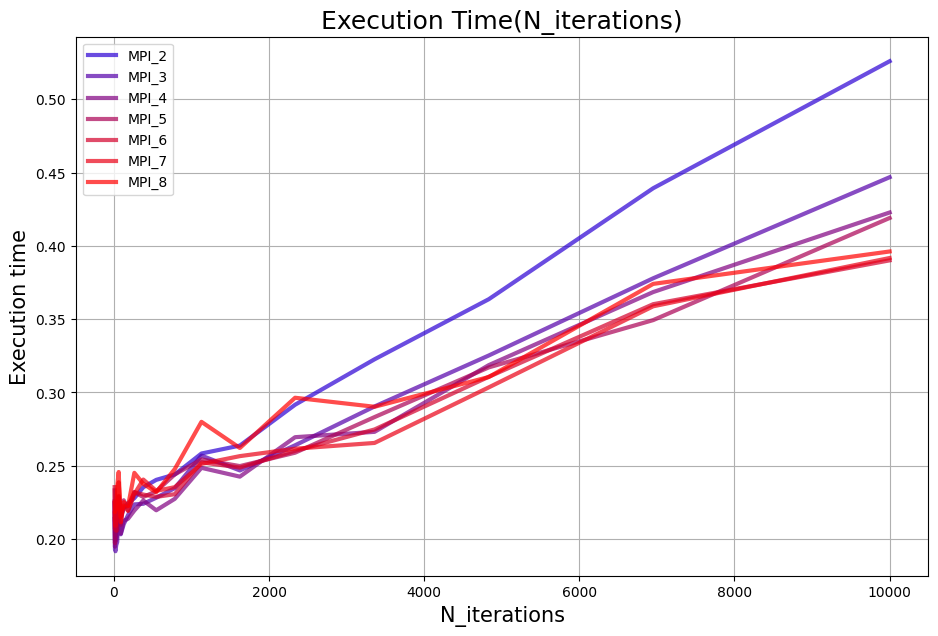

In [ ]:
plt.style.use('default')
plt.figure(figsize=(11,7))
plt.title("Execution Time(N_iterations)", fontsize = 18)
plt.xlabel('N_iterations', fontsize = 15)
plt.ylabel('Execution time', fontsize = 15)
plt_colors = ['#0000ff','#2b00d4', '#5500aa', '#800080', '#aa0055', '#d4002b', '#ea0015',  '#ff0000']


for i in range(1, mpi_results.shape[1]):
    y = mpi_results[:,i]
    plt.plot(interval,y, label = "MPI_"+str(i+1), color = plt_colors[i], alpha = 0.7, linewidth = 3.)
    

# plt.plot(interval, np_results, label = 'numpy')
# plt.plot(interval, cp_results, label = 'cupy')
# plt.plot(interval, jit_results, label = 'jit')

plt.grid()
#plt.yscale('log')
plt.legend()
plt.show()



So, we can see that the more processes we have, the faster our calculations are if we have a lot number of iterations (more than 10k). Otherwise, we can notice that is not reasonable to use many processes. It's enough to use about 5 processes.

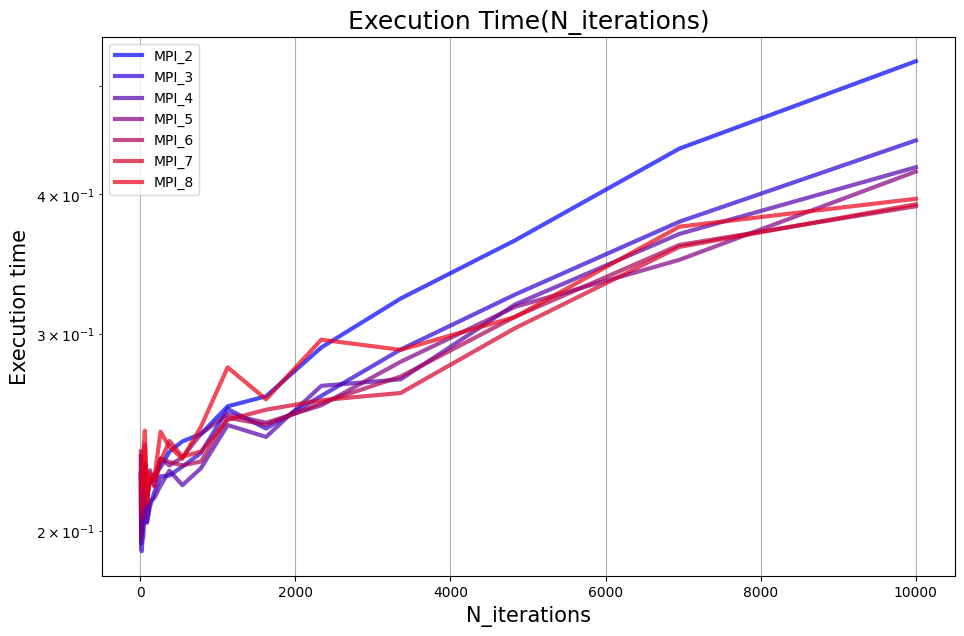

In [ ]:
plt.style.use('default')
plt.figure(figsize=(11,7))
plt.title("Execution Time(N_iterations)", fontsize = 18)
plt.xlabel('N_iterations', fontsize = 15)
plt.ylabel('Execution time', fontsize = 15)
plt_colors = ['#0000ff','#2b00d4', '#5500aa', '#800080', '#aa0055', '#d4002b', '#ea0015',  '#ff0000']


for i in range(1, mpi_results.shape[1]):
    y = mpi_results[:,i]
    plt.plot(interval , y, label = "MPI_"+str(i+1), color = plt_colors[i-1], alpha = 0.7, linewidth = 3.)
    

# plt.plot(interval, np_results, label = 'numpy')
# plt.plot(interval, cp_results, label = 'cupy')
# plt.plot(interval, jit_results, label = 'jit')

plt.grid()
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

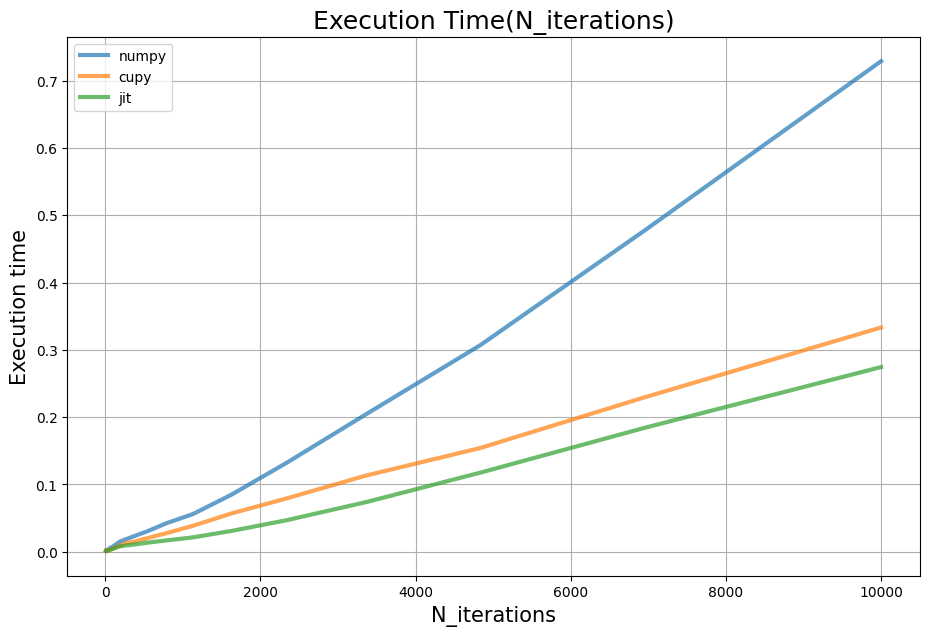

In [ ]:
plt.style.use('default')
plt.figure(figsize=(11,7))
plt.title("Execution Time(N_iterations)", fontsize = 18)
plt.xlabel('N_iterations', fontsize = 15)
plt.ylabel('Execution time', fontsize = 15)


plt.plot(interval, np_results, label = 'numpy',alpha = 0.7, linewidth = 3.)
plt.plot(interval, cp_results, label = 'cupy', alpha = 0.7, linewidth = 3.)
plt.plot(interval, jit_results, label = 'jit', alpha = 0.7, linewidth = 3.)
plt.legend()
plt.grid()
plt.show()

Here we can see that Jit and cupy versions are much faster than the usual version. 
It's also interesting that the Jit version is faster than GPU calculations. I think this task is too easy for using GPU calculations and with more difficult tasks GPU would deal better

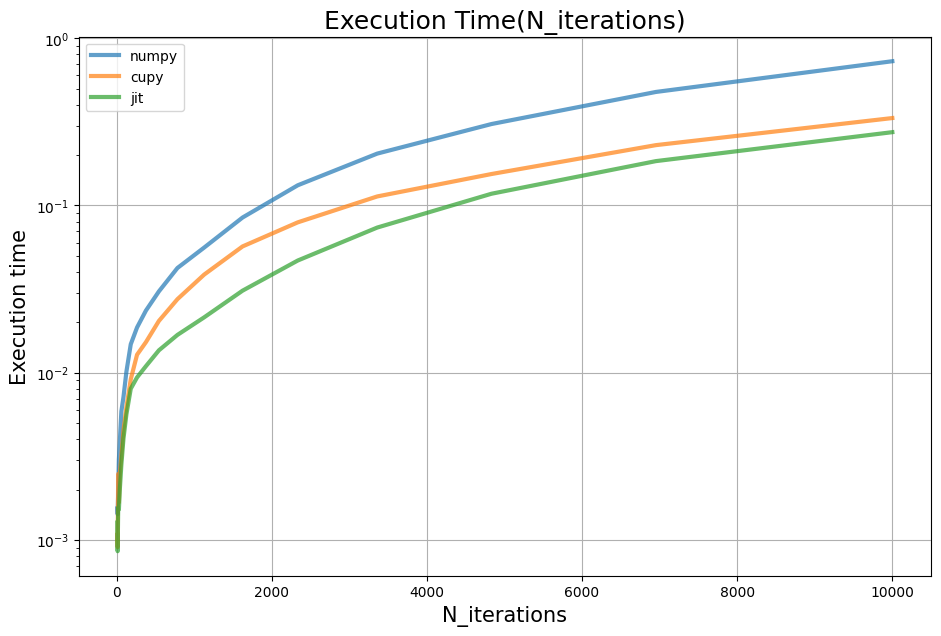

In [ ]:
plt.style.use('default')
plt.figure(figsize=(11,7))
plt.title("Execution Time(N_iterations)", fontsize = 18)
plt.xlabel('N_iterations', fontsize = 15)
plt.ylabel('Execution time', fontsize = 15)

plt.yscale('log')
plt.plot(interval, np_results, label = 'numpy',alpha = 0.7, linewidth = 3.)
plt.plot(interval, cp_results, label = 'cupy', alpha = 0.7, linewidth = 3.)
plt.plot(interval, jit_results, label = 'jit', alpha = 0.7, linewidth = 3.)
plt.legend()
plt.grid()
plt.show()

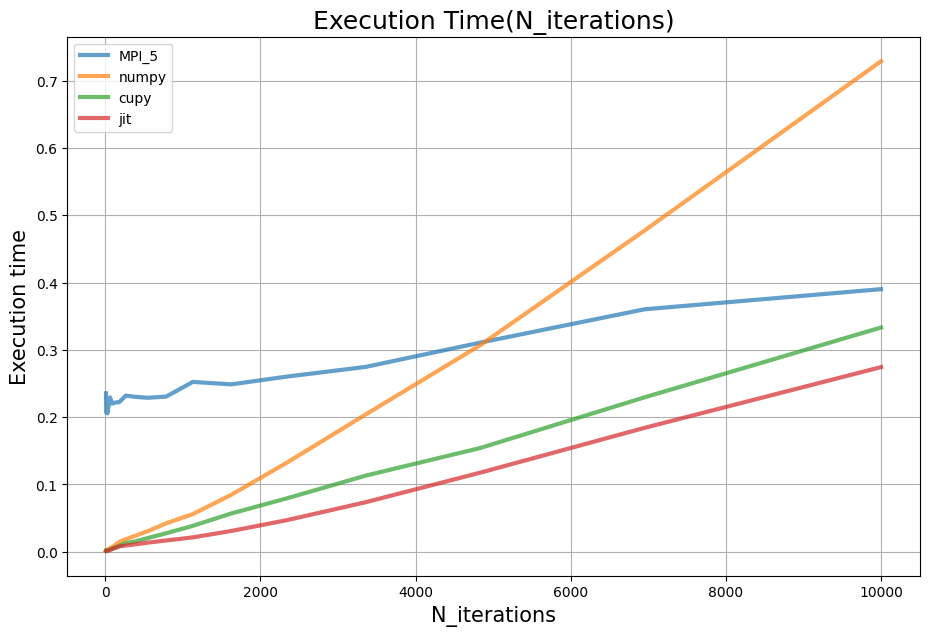

In [ ]:
plt.style.use('default')
plt.figure(figsize=(11,7))
plt.title("Execution Time(N_iterations)", fontsize = 18)
plt.xlabel('N_iterations', fontsize = 15)
plt.ylabel('Execution time', fontsize = 15)

#plt.yscale('log')
plt.plot(interval, mpi_results[:,5], label = 'MPI_5',alpha = 0.7, linewidth = 3. )
plt.plot(interval, np_results, label = 'numpy',alpha = 0.7, linewidth = 3.)
plt.plot(interval, cp_results, label = 'cupy', alpha = 0.7, linewidth = 3.)
plt.plot(interval, jit_results, label = 'jit', alpha = 0.7, linewidth = 3.)
plt.legend()
plt.grid()
plt.show()

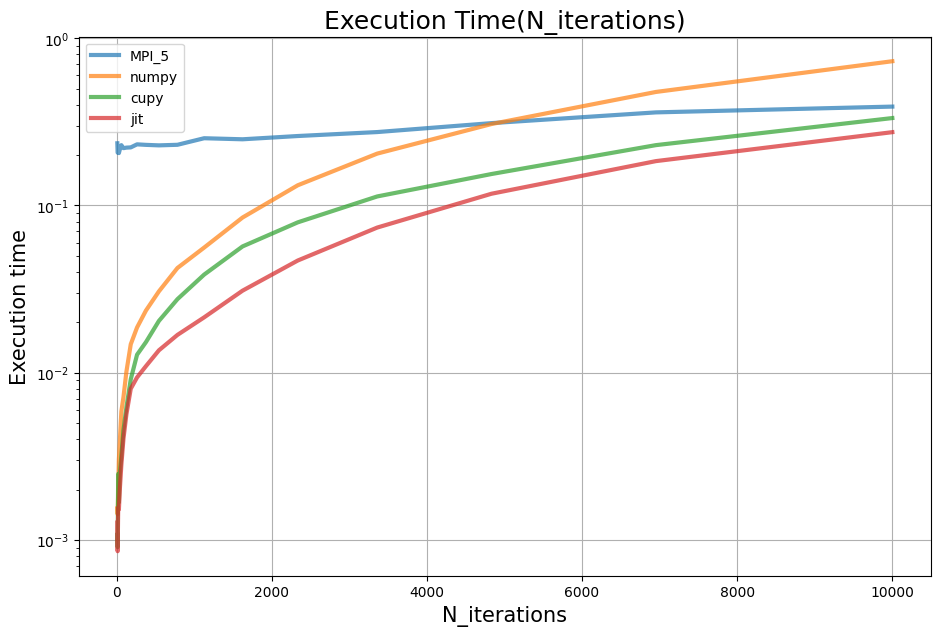

In [ ]:
plt.style.use('default')
plt.figure(figsize=(11,7))
plt.title("Execution Time(N_iterations)", fontsize = 18)
plt.xlabel('N_iterations', fontsize = 15)
plt.ylabel('Execution time', fontsize = 15)

plt.yscale('log')
plt.plot(interval, mpi_results[:,5], label = 'MPI_5',alpha = 0.7, linewidth = 3. )
plt.plot(interval, np_results, label = 'numpy',alpha = 0.7, linewidth = 3.)
plt.plot(interval, cp_results, label = 'cupy', alpha = 0.7, linewidth = 3.)
plt.plot(interval, jit_results, label = 'jit', alpha = 0.7, linewidth = 3.)
plt.legend()
plt.grid()
plt.show()

And as a result, we can see that it's reasonable to use Jit version for this task almost for the whole interval. Also, it's useless to use MPI with a few iterations. 

Also, I checked other similar competitions. We can see almost the same results. And Cupy version becomes faster than Jit after 10^6 number of samples.

https://www.kaggle.com/jiweiliu/qwk-cupy-vs-numpy-vs-numba

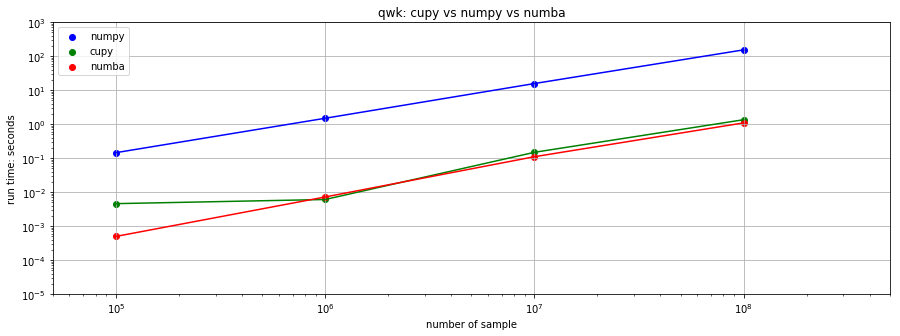